# Tarea 3: Redes Neuronales

ME4707 - Robótica - Semestre 2021-2

Profesor: Juan C. Zagal - Auxiliar: Raimundo Lorca - Laboratorios: Gaspar Fábrega

# 1. Introducción

Entre los algoritmos más comunes dentro del Machine Learning (ML) se encuentran las Redes Neuronales o Neural Networks (NN) que son algoritmos bioinspirados en la forma en que nuestro cerebro procesa información mediante transmisión de señales eléctricas entre las neuronas. Al igual que la mente de un bebé va aprendiendo al ir experimentando y creciendo, las redes neuronales aprenden del error. En el caso del Aprendizaje Supervisado es posible utilizar conjuntos de entrenamiento donde existen pares de datos de entrada y salida `(X, Y)`, ya conocidos, para que la red aprenda de estos a extraer las características y patrones necesarios para llevar a cabo la tarea deseada, ya sea de clasificación o regresión. 

De este modo, inicialmente las redes comienzan por predecir resultados totalmente erróneos a partir de los datos entregados. No obstante, a medida que esta va siendo entrenada, va ajustando sus parámetros internos para corregir sus respuestas y acercarse los más posible a los resultados esperados.

Las Neural Networks se estructuran en una red de nodos generalmente ordenados por capas, que mediante una serie de ponderaciones y conexiones convierten una serie de inputs X en outputs Y. Dependiendo de como se estructuren las redes neuronales, estas pueden cumplir diferentes funciones, permitiéndoles ser aplicadas en una gran variedad de problemas, desde prevensión de fraudes bancarios hasta detección de tumores mediante radiografías.

En esta tarea los problemas se abordarán desde un punto de vista más analítico, acercando a las y los estudiantes al funcionamiento y programación de redes neuronales al observar el desempeño de estas en problemas de distinta índole.

# 2. Formato de entrega
La tarea se desarrollará en [Google Colab](https://colab.research.google.com/) en un entorno de Python 3. Debe trabajar sobre este mismo archivo .ipynb completando lo que se requiere en cada problema. Se debe entregar:
- Reporte de resultados (en un archivo .pdf) y análisis de estos de acuerdo con las distintas partes de la tarea.
- En el archivo .ipynb deben dejar la mejor red que hayan logrado.

# 3. Problema Clasificación ANN

Se comenzará por analizar un problema de clasificación bastante simple inspirado en el Neural Network Playground de TensorFlow (https://playground.tensorflow.org). En este caso, los puntos son segmentados o bien, etiquetados, en dos regiones dentro de los cuadrantes que se muestran en el diagrama a continuación. Así, el objetivo de nuestro modelo será clasificar la etiqueta de los puntos dentro de este espacio apartir del par de puntos $(x1, x2)$ como valores de entrada.


<img src="https://raw.githubusercontent.com/RaimundoLorca/Practico_taller/main/problema_01_ref.png" height="280">


## 3.1 Dataset
En este problema se dispone de una serie de puntos (dataset) en el espacio cartesiano $(x_1, x_2)$, los cuales son clasificados en base a su posición en el espacio. Lea con atención el código a continuación que permite la generación de este dataset `(X, Y)`.

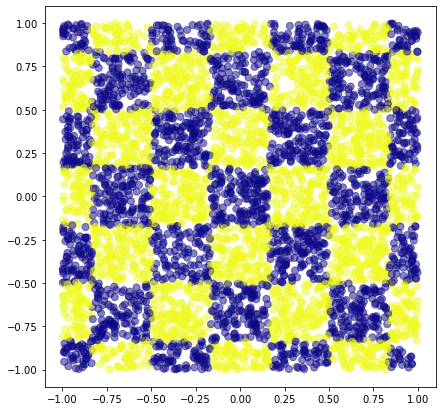

In [2]:
# generación dataset------

# importar librerías
import random
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, pi

# cantidad de datos en el dataset
data_size = 5000

# proporción de ruido en el dataset
data_noise = 0.0

# inicializar sets de datos
# X contiene los puntos cartesianos (x, y)
# Y contiene las etiquetas de clasificación de cada punto
# donde 1 significa que se encuentra dentro del radio y 0 que no.
X = np.zeros( (data_size, 2) )
Y = np.zeros( (data_size, 2) )

# generar datos al azar
for i in np.arange(data_size):
  x1 = 2*random.random() - 1
  x2 = 2*random.random() - 1

  # agregar al set X de puntos
  X[i, 0] = x1
  X[i, 1] = x2

  # agregar etiqueta al set Y
  if cos(x1*3*pi)*cos(x2*3*pi) > 0.0:
    Y[i, 0] = 0
    Y[i, 1] = 1
  else:
    Y[i, 0] = 1
    Y[i, 1] = 0

  # agregar ruido al dato (utilizado más adelante)
  if random.random() < data_noise:
    Y[i, :] = 1 - Y[i, :]

# plotear distribución en el dataset
plt.figure( figsize=(7,7) )
plt.scatter(X[:,0], X[:,1], c=Y[:,0], cmap='plasma', alpha=0.5, s=50)

## 3.2 Data Splitting

Teniendo ya el dataset para el entrenamiento de la NN, se debe dividir este en dos sets: uno de entrenamiento (`training set`) y otro de testing (`testing set`). El primero es utilizado, como su nombre lo indica, en el entrenamiento de la red neuronal; mientras que el segundo es utilizado para evaluar el _accuracy_ de la red ya entrenada.

Como la red es evaluada con datos que "nunca ha visto" durante el entrenamiento, este resultado permite observar si la red ha logrado generalizar el problema o si se ha _overfitteado_ (aprenderse los datos de entrenamiento de "memoria").

El _data splitting_ se puede lograr con el siguiente código:

In [3]:
# importar librerías
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# generar sets de datos de training y testing
# la varibale test_size permite controlar la proporción entre los datos de testing y training.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

## 3.3 Model Setup

Con los sets de entrenamiento y testing listos se puede dar paso a la configuración y entrenamiento de la red neuronal. Para esto se utilizará la librería `keras` o `tf.keras` de `TensorFlow`. Keras es una API de alto nivel para la creación y el entrenamiento de modelos de deep learning. Está orientada y diseñada para la construcción de modelos de forma modular o en bloques. De este modo, ofrece un framework mucho más amigable e intuitivo para principiantes, a la vez que mantiene un estructura personalizable y versátil que permite a usuarios más avanzados incorporar nuevas ideas.

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/workshop_02/bin/keras_logo.png" width="400">

Los elemenos básicos para la construcción de un modelo o `keras.Model` consisten en las capas o `layers` del modelo. En este sentido, configurar un modelo en Keras resulta en ir uniendo o conectando capas `keras.layers` de manera secuencial.

Para comenzar e introducir el framework de esta librería, construiremos un modelo o red neuronal `Sequential` a partir de únicamente capas `keras.layers.Dense` y otras capas elementales.
- https://keras.io/api/layers/
- https://keras.io/api/layers/activations/

En términos generales, compondremos nuestro modelo de una serie de capas `Dense`, que se encargarán de procesar la información y los patrones de los datos de entrada hasta una última capa `Dense` con únicamente dos nodos que determinarán las etiquetas de los puntos $(x_1, x_2)$ que se ingresen al modelo.
A continuación se presenta el código necesario para configurar una red de este tipo.


In [4]:
# importar librerías
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.utils import plot_model

# inicializar modelo keras.Sequential
model = Sequential()

# ---
# primero debemos agregar nuestra capa Input donde debemos especificar
# las dimensiones de los datos que se ingresarán al modelo
input_dim = ( 2, )
model.add( Input( shape=input_dim ) )

# ---
# ahora debemos ir agregando nuestras capas Dense.
# https://keras.io/api/layers/core_layers/dense/

# las keras.layers.Dense reciben la cantidad de nodos o units dentro
# de la capa y la función de activación que operarán.
# https://keras.io/api/layers/activations/
model.add(Dense(units = 12, activation = 'relu'))
model.add(Dense(units = 12, activation = 'relu'))


# ---
# por último debemos configurar nuestra capa de salida
# dado que el modelo consiste en uno de clasificación emplearemos
# la función softmax, donde cada nodo indicará la probabilidad de que
# los datos correspondan a una de las etiquetas o estados de salud.
labels_num = 2
model.add(Dense(units = labels_num, activation = 'softmax'))

# imprimir resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                36        
_________________________________________________________________
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 26        
Total params: 218
Trainable params: 218
Non-trainable params: 0
_________________________________________________________________


Parte de este analisis consiste en experimentar con distintas cantidades de capas, nodos e incluso funciones de activación (https://keras.io/activations/). Sientase en libertad de modificar la arquitectura de esta red según le parezca.

Para entrenar esta red o bien llamado, modelo, basta compilarlo y entrenarlo con los sets de datos generados anteriormente. En este caso utilizaremos los datos de `testing` como datos de validación para monitorear directamente el desempeño del modelo sobre el conjunto de evaluación.

In [9]:
# ---
# compilar modelo siguiendo como función de pérdida
# la categorical crossentropy, 'categorical_crossentropy'
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# ---
# realizar rutina de entrenamiento
train_history = model.fit(X_train, Y_train,
                          batch_size=128, epochs=200,
                          validation_data=(X_test, Y_test) )

Epoch 1/200
32/32 [==============================] - 0s 8ms/step - loss: 0.6940 - accuracy: 0.4990 - val_loss: 0.6913 - val_accuracy: 0.5060
Epoch 2/200
32/32 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5197 - val_loss: 0.6905 - val_accuracy: 0.5090
Epoch 3/200
32/32 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5153 - val_loss: 0.6901 - val_accuracy: 0.4990
Epoch 4/200
32/32 [==============================] - 0s 2ms/step - loss: 0.6905 - accuracy: 0.5132 - val_loss: 0.6898 - val_accuracy: 0.5100
Epoch 5/200
32/32 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.5230 - val_loss: 0.6895 - val_accuracy: 0.5250
Epoch 6/200
32/32 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5213 - val_loss: 0.6892 - val_accuracy: 0.5270
Epoch 7/200
32/32 [==============================] - 0s 2ms/step - loss: 0.6896 - accuracy: 0.5063 - val_loss: 0.6889 - val_accuracy: 0.5130
Epoch 8/200
3

Epoch 59/200
32/32 [==============================] - 0s 3ms/step - loss: 0.6648 - accuracy: 0.5975 - val_loss: 0.6633 - val_accuracy: 0.6000
Epoch 60/200
32/32 [==============================] - 0s 3ms/step - loss: 0.6644 - accuracy: 0.5845 - val_loss: 0.6630 - val_accuracy: 0.5960
Epoch 61/200
32/32 [==============================] - 0s 3ms/step - loss: 0.6640 - accuracy: 0.5993 - val_loss: 0.6621 - val_accuracy: 0.5920
Epoch 62/200
32/32 [==============================] - 0s 3ms/step - loss: 0.6632 - accuracy: 0.5835 - val_loss: 0.6617 - val_accuracy: 0.5980
Epoch 63/200
32/32 [==============================] - 0s 2ms/step - loss: 0.6624 - accuracy: 0.5928 - val_loss: 0.6608 - val_accuracy: 0.6050
Epoch 64/200
32/32 [==============================] - 0s 3ms/step - loss: 0.6623 - accuracy: 0.5965 - val_loss: 0.6608 - val_accuracy: 0.6130
Epoch 65/200
32/32 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.5945 - val_loss: 0.6602 - val_accuracy: 0.5970
Epoch 

32/32 [==============================] - 0s 3ms/step - loss: 0.6122 - accuracy: 0.6488 - val_loss: 0.6250 - val_accuracy: 0.6350
Epoch 174/200
32/32 [==============================] - 0s 3ms/step - loss: 0.6116 - accuracy: 0.6647 - val_loss: 0.6266 - val_accuracy: 0.6420
Epoch 175/200
32/32 [==============================] - 0s 3ms/step - loss: 0.6125 - accuracy: 0.6603 - val_loss: 0.6270 - val_accuracy: 0.6320
Epoch 176/200
32/32 [==============================] - 0s 3ms/step - loss: 0.6112 - accuracy: 0.6640 - val_loss: 0.6231 - val_accuracy: 0.6370
Epoch 177/200
32/32 [==============================] - 0s 3ms/step - loss: 0.6116 - accuracy: 0.6668 - val_loss: 0.6246 - val_accuracy: 0.6330
Epoch 178/200
32/32 [==============================] - 0s 3ms/step - loss: 0.6128 - accuracy: 0.6568 - val_loss: 0.6236 - val_accuracy: 0.6440
Epoch 179/200
32/32 [==============================] - 0s 3ms/step - loss: 0.6124 - accuracy: 0.6633 - val_loss: 0.6241 - val_accuracy: 0.6430
Epoch 180/200

## 3.3 Model Evaluation

Para evaluar el desempeño de este modelo de clasificación existen múltiples herramientas:
-  Gráfico de función de pérdida: La función de pérdida o _loss function_ es el paramétro que se va optimizando a medida que la red se entrena. La red neuronal va ajustando los pesos de ponderación entre los nodos tal de minimizar este paramétro. En el gráfico de función de perdida se puede visualizar el desempeño del entrenamiento del modelo y además la convergencia entre la curva de `training` y `validation`. Si la curva de `validation` se escapa considerablemente de la curva de `training` esto es un indicador de que el modelo ha sufrido _overfitting_ y por tanto ha perdido generalidad (se aprende los datos de `training` de memoria).

- Matriz de confusión: Esta tabla permite comparar las predicciones del modelo versus las etiquetas reales de los datos.

- Heat Map o Mapa de Clasificación: En el caso de modelos que operan sobre datos 2D, o en el espacio cartesiano, es posible visualizar el resultado de la red neuronal dentro de todo el dominio de los datos (espacio cartesiano). Así es posible visualizar de forma más directa el criterio de clasificación del modelo.

Dentro del github del curso `roboticafcfm` se encuentran implementadas las funciones `plot_loss_function`, `plot_confusion_matrix` y `plot_classification_map` para facilitar el uso de estas herramientas. Para cargarlas dentro del entorno de Colab debe ejecutar el siguiente bloque de código.

In [13]:
!git clone https://github.com/RaimundoLorca/roboticafcfm2021-2.git
%cd /content/roboticafcfm2021-2

[WinError 3] El sistema no puede encontrar la ruta especificada: '/content/roboticafcfm2021-2'
C:\Users\skill\Desktop\022021\roboticafcfm2021-2


"git" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Una vez importado el github del curso, ejecute el siguiente bloque de código y observe los resultados del modelo.

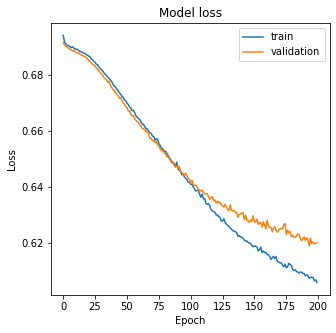

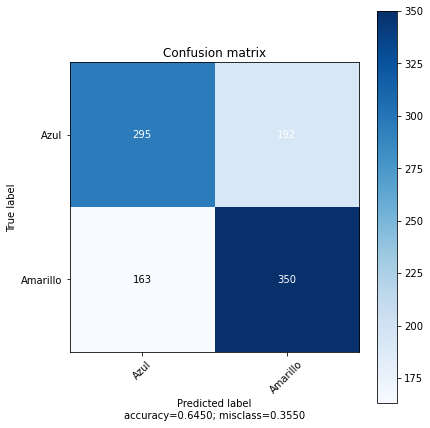

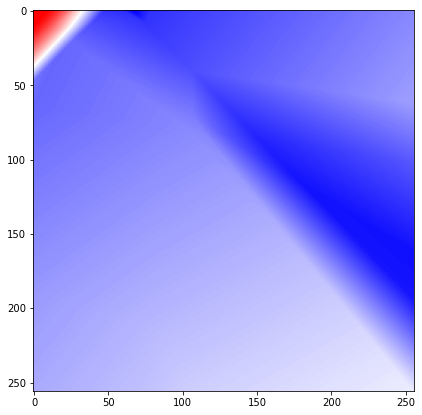

In [17]:
from utils import plot_loss_function
from utils import plot_confusion_matrix
from utils import plot_classification_map

# obtener predicciones de X_test con model.predict
Y_pred = model.predict(X_test)

# para que el resultado nos sea más intuitivo transformaremos
# las etiquetas nuevamente a non one-hot-encoding
# utilizando np.argmax
Y_pred = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_test, axis = 1)

# plot gráfico de función de pérdida
plot_loss_function(train_history)

# matriz de confusión
plot_confusion_matrix(Y_true, Y_pred,
                      target_names=['Azul', 'Amarillo'], figsize=(6, 6))

# classification map
plot_classification_map(model, (0,1), (0,1), 256)

Podemos además visualizar la red completa y los pesos entre los nodos de las capas, ejecute la siguiente celda de código oculto (se ha colapsado la pestaña para disminuir el espacio utilizado por esta):

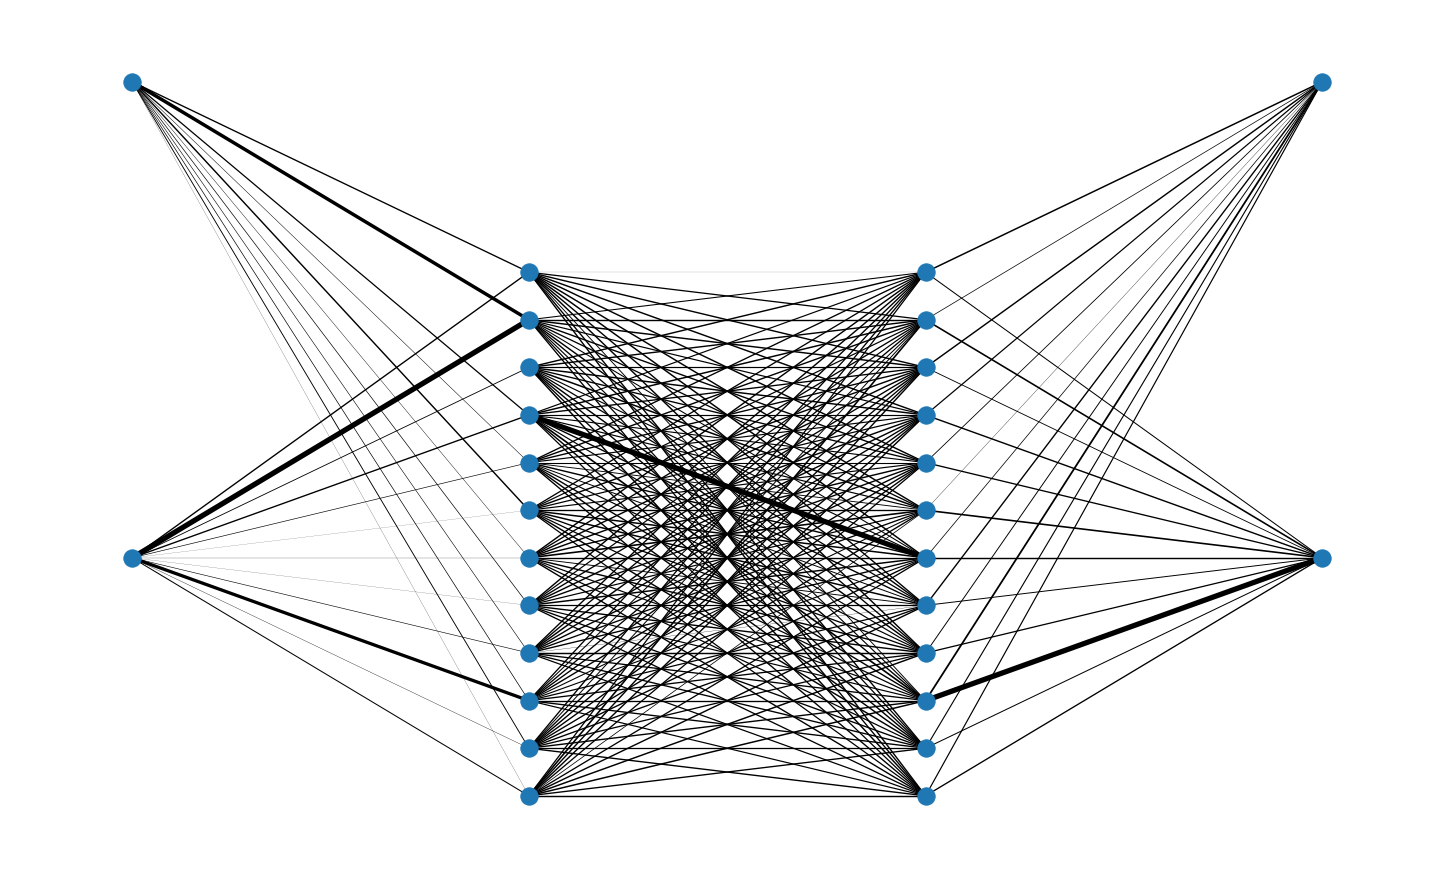

In [63]:
#@title Graficar nodos y pesos de la red:
#@markdown El siguiente bloque de código genera un grafico de la red neuronal utilizando la libreria NETWORKX. Simplemente haga click en ejecutar celda para ver sus resultados.
#@ 
#@markdown Para leer el código, haga doble click en este bloque de texto o en "mostrar codigo" y se expandirá el contenido

# Largo de el modelo (cantidad de pesos)
length = len(model.trainable_weights)

# Se define una constante para escalar el peso de manera logaritmica
e = 0.005

# importamos la libreria
import networkx as nx

# iniciamos el grafo
G = nx.Graph()

# definimos variable utiles para ubicar de manera correcta los nodos en el plano
k1 = 0
k2 = 0
n = 0

# iteramos sobre cada arreglo de pesos
for w_i in range(0,length,2):
  layer = model.trainable_weights[w_i]

  if np.min(layer.value())<0:
    layer = np.log(e+layer-np.min(layer.value())) #np.min(layer.value())
  else:
    layer = np.log(e+layer)

  x = layer.shape[0]
  k1 = k2
  k2+=x
  y = layer.shape[1]

  # para cada arreglo, se inicializan los nodos y se crean las conexiones entre ellos

  for i in range(x):
    if w_i == 0:
      G.add_node(i,pos=(n,-5+10*i))

    if y != 2:
      for j in range(y):
        G.add_node(j+k2,pos=(n+1,j-10))
        G.add_edge(i+k1, j+k2, weight = layer[i][j])
    else:
      for j in range(y):
        G.add_node(j+k2,pos=(n+1,-5+10*j))
        G.add_edge(i+k1, j+k2, weight = layer[i][j])
      
  n+=1

# se extrae informacion de posicion de nodos y peso de las conexiones
pos=nx.get_node_attributes(G,'pos')
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]

# graficamos
plt.figure(figsize=(20,12)) 
nx.draw(G,pos,with_labels=False, width = weights)
plt.show()




## 3.4 Preguntas

- Registre los resultados de esta primera red neuronal "simple" en su reporte. Luego, agregue más capas a la red y aumente la cantidad de nodos de estas. También pruebe utilizando distintas funciones de activación. Mejore la red lo más posible procurando maximizar el parámetro _val_acc_ mostrado durante el entrenamiento (mientras más cercano a 1.0 mejor). Registre los resultados de esta red mejorada y comente sobre la razón de este mejor desempeño.
- En la sección en que se genera el dataset existe el parámetro _data_noise_, este define el porcentaje de ruido a agregar al dataset. Elija tres valores entre [0.05, 0.5] y entrene su red mejorada con estos tres nuevos sets con ruido. Registre los resultados y comente sobre los cambios en el desempeño (utilice los gráficos).
- ¿Qué representa la magnitud de los pesos y cuál es su relación con el input de las conexiones? En específico, para pesos positivos, cercanos a cero y negativos.

# 4. Problema Clasificación CNN
 
A partir del problema anterior, es claro que las redes neuronales son capaces de resolver problemas de clasificación simples, incluso ante la presencia de algo de ruido. La pregunta entonces radica si son capaces de resolver problemas de clasificación más complejos, como por ejemplo, clasificación de imágenes digitales.

En este problema se trabajará con un dataset que contiene cerca de 60.000 imágenes de `32x32px` correspondientes a 10 clases distintas (perros, ranas, barcos, camiones, etc.) llamado CIFAR-10. El objetivo de este problema es desarrollar una Red Neuronal Convolucional o Convolutional Neural Network (CNN) capaz de discernir entre las distintas clases y lograr clasificar correctamente cada imagen de acuerdo a su clase correspondiente.

Mas información sobre el dataset: https://www.cs.toronto.edu/~kriz/cifar.html

<img src="https://miro.medium.com/max/944/1*6XQqOifwnmplS22zCRRVaw.png" height="250"> <img src="https://raw.githubusercontent.com/RaimundoLorca/Practico_taller/main/problema_02_ref.png" height="250">

TIP: Para que el modelo no demore tanto en entrenarse, es conveniente cambiar el tipo de entorno de ejecución a uno acelerado de GPU. Esto lo pueden hacer en Entorno de Ejecución --> Cambiar Tipo de Entorno de Ejecución --> Acelerador de hardware --> GPU.

## 4.1 Dataset

El dataset CIFAR-10 puede ser obtenido corriendo el código a continuación.

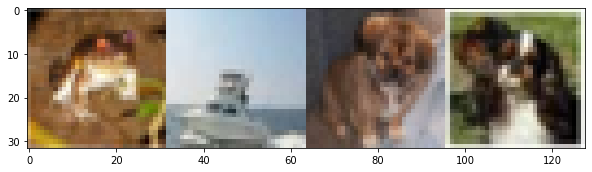

In [4]:
# importar librerías
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt 

# importar sets de training y testing
(X_train, Y_train_non_one_hot), (X_test, Y_test_non_one_hot) = cifar10.load_data()

# ---
# visualizar algunas imágenes dentro del dataset
imgs = np.hstack( [X_train[0,:,:], X_train[100,:,:],
                   X_train[217,:,:], X_train[500,:,:]] )

plt.figure( figsize=(10,10) )
plt.imshow(imgs)


Como se puede observar, el dataset ya se encuentra separado en sets de training y testing. No obstante, es necesario algo de procesamiento previo al entrenamiento. Corra el bloque de código a continuación para preparar los datos.

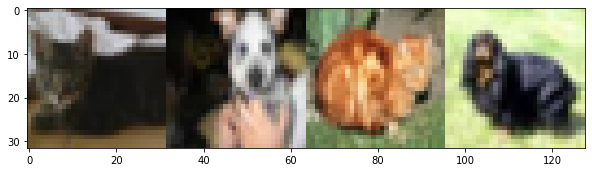

In [5]:
# importar librerías
from tensorflow.keras.utils import to_categorical
import numpy as np

# ---
# dado que las etiquetas no vienen con one-hot encoding las transformamos a estas.
# one-hot-encoding consiste en codificar las etiquetas de la forma [0, 0, 1]
# cuando, por ejemplo, se tienen tres clases. Así, esta estructura es compatible
# con la salida de una capa softmax.

# para esto se puede utilizar la función to_categorical de keras.utils
Y_train = to_categorical(Y_train_non_one_hot, 10)
Y_test = to_categorical(Y_test_non_one_hot, 10)

# ---
# para un experimento posterior aislaremos las clases correspondientes
# a las clases de perros y gatos, donde la etiqueta 5 corresponde a perros
# y la etiqueta 3 a gatos.
X_dc_train = np.zeros( (10000, 32, 32, 3) )
Y_dc_train = np.zeros( (10000, 1) )

X_dc_test = np.zeros( (2000, 32, 32, 3) )
Y_dc_test = np.zeros( (2000, 1) )


n = 0
# recorreremos todas la imágenes en cifar-10
for i in range(X_train.shape[0]):
  # si tiene la etiqueta correspondiente a perro
  if (Y_train_non_one_hot[i][0] == 5):
    # agregamos la imágen al dataset
    X_dc_train[n,:,:,:] = X_train[i,:,:,:]
    Y_dc_train[n] = 0
    n = n+1

  # si tiene la etiqueta correspondiente a gato
  elif (Y_train_non_one_hot[i][0] == 3):
    X_dc_train[n,:,:,:] = X_train[i,:,:,:]
    Y_dc_train[n] = 1
    n = n+1

# datos testing
n = 0
for i in range(X_test.shape[0]):
  # si tiene la etiqueta correspondiente a perro
  if (Y_test_non_one_hot[i][0] == 5):
    X_dc_test[n,:,:,:] = X_test[i,:,:,:]
    Y_dc_test[n] = 0
    n = n+1
  # si tiene la etiqueta correspondiente a gato
  elif (Y_test_non_one_hot[i][0] == 3):
    X_dc_test[n,:,:,:] = X_test[i,:,:,:]
    Y_dc_test[n] = 1
    n = n+1

# pasamos a one hot encoding
Y_dc_train = to_categorical(Y_dc_train, 2)
Y_dc_test = to_categorical(Y_dc_test, 2)

# ---
# mostrar ejemplos
imgs = np.hstack( [X_dc_train[0,:,:], X_dc_train[100,:,:],
                   X_dc_train[200,:,:], X_dc_train[300,:,:]] )

plt.figure( figsize=(10,10) )
plt.imshow(np.uint8(imgs))


## 4.2 Model Setup
En el desarrollo de una red CNN hay tres nuevos tipos de capas a tomar en consideración.
- Conv2D (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): Esta capa en vez de componerse de nodos se compone de filtros (como los vistos en el capítulo de visión computacional), cada uno de estos filtros es convolucionado con la imagen de entrada produciendo una nueva imagen _filtrada_ que pasa a la siguiente capa.
- MaxPooling2D (https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): A medida que avanza la información a través de la red, conviene ir reduciendo el tamaño de las imágenes tal de ir aislando únicamente la información relevante (_features_). Además, así se reduce significativamente el costo computacional durante el entrenamiento. Este tipo de capas reduce las dimensiones de las imágenes que entran a estas.

- Flatten (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten): Dado que después de todo este es un problema de clasificación, la última capa debe consistir en un par de nodos softmax que entreguen las etiquetas. Para conectar las imágenes de las capas anteriores a esta capa (o a capas Dense) es necesario agregar una capa Flatten que transforme la información de las imágenes en vectores de 1D.

A continuación, se presenta una arquitectura bastante simple de una CNN que cumpla el propósito de este problema. La idea es que, al igual que en el problema anterior, vaya modificando la arquitectura tal de mejorarla.

In [2]:
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import plot_model

# inicializar modelo keras.Sequential
model = Sequential()

# ---
# primero debemos agregar nuestra capa Input donde debemos especificar
# las dimensiones de los datos que se ingresarán al modelo
# las capas Conv2D reciben tensores de la forma (height, width, channels)
input_dim = ( 32, 32, 3)
model.add( Input( shape=input_dim ) )

# ---
# ahora debemos ir agregando nuestras capas Conv2D y Pooling.

# las keras.layers.Conv2D reciben la cantidad de filtros dentro de la capa,
# el tamaño de estos filtros y la función de activación con que operarán.
# https://keras.io/api/layers/convolution_layers/convolution2d/

# las keras.layers.MaxPooling2D reciben el tamaño de la ventana sobre
# la cual llevarán a cabo el down-sampling
# https://keras.io/api/layers/pooling_layers/max_pooling2d/

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 48, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(filters = 48, kernel_size = (3, 3), activation = 'relu', padding = 'same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))

# ---
# ahora debemos ir agregando nuestras capas Dense para procesar la
# información hasta la capa de salida.
# https://keras.io/api/layers/core_layers/dense/

model.add(Flatten())

model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 64, activation = 'relu'))

# ---
# por último debemos configurar nuestra capa de salida
# dado que el modelo consiste en uno de clasificación emplearemos
# la función softmax, donde cada nodo indicará la probabilidad de que
# los datos correspondan a una de las etiquetas (10 clases).
model.add(Dense(units = 10, activation = 'softmax'))

# imprimir resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 48)        13872     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 48)        20784     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 48)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          2

Antes de empezar a entrenar el modelo, se almacenarán los parametros entrenables (weights/pesos), con el fin de compararlos antes y después de entrenar la red. (Simplemente corra el bloque de codigo)

In [4]:
from copy import deepcopy

#Se guardan los valores de los parametros (weights) antes 
#de entrenar el modelo
weights_before_training = deepcopy(model.trainable_weights) #Todas las capas
weights_before_training_2 = deepcopy(model.trainable_weights[2]) #Solo la segunda capa

Luego, al igual que en el caso anterior, para entrenar esta red o bien llamado, modelo, basta compilarlo y entrenarlo con los sets de datos.

In [5]:
# ---
# compilar modelo siguiendo como función de pérdida
# la categorical crossentropy, 'categorical_crossentropy'
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# ---
# realizar rutina de entrenamiento
train_history = model.fit(X_train, Y_train,
                          batch_size=64, epochs=200,
                          validation_data=(X_test, Y_test) ) #batch_size=128

Epoch 1/200
782/782 [==============================] - 5s 6ms/step - loss: 1.5659 - accuracy: 0.4535 - val_loss: 1.2576 - val_accuracy: 0.5486
Epoch 2/200
782/782 [==============================] - 4s 6ms/step - loss: 1.0893 - accuracy: 0.6168 - val_loss: 1.0603 - val_accuracy: 0.6322
Epoch 3/200
782/782 [==============================] - 4s 6ms/step - loss: 0.8985 - accuracy: 0.6877 - val_loss: 0.8986 - val_accuracy: 0.6873
Epoch 4/200
782/782 [==============================] - 4s 6ms/step - loss: 0.7736 - accuracy: 0.7316 - val_loss: 0.9041 - val_accuracy: 0.6957
Epoch 5/200
782/782 [==============================] - 4s 6ms/step - loss: 0.6764 - accuracy: 0.7630 - val_loss: 0.8948 - val_accuracy: 0.7058oss: 0.6
Epoch 6/200
782/782 [==============================] - 4s 5ms/step - loss: 0.6037 - accuracy: 0.7876 - val_loss: 0.8871 - val_accuracy: 0.7077cy: 
Epoch 7/200
782/782 [==============================] - 5s 6ms/step - loss: 0.5298 - accuracy: 0.8135 - val_loss: 0.9187 - val_accu

782/782 [==============================] - 4s 6ms/step - loss: 0.0964 - accuracy: 0.9736 - val_loss: 2.1298 - val_accuracy: 0.7034
Epoch 58/200
782/782 [==============================] - 4s 6ms/step - loss: 0.0988 - accuracy: 0.9718 - val_loss: 2.2475 - val_accuracy: 0.69931s - loss: 0.100 - ETA: 0s - los
Epoch 59/200
782/782 [==============================] - 5s 6ms/step - loss: 0.0967 - accuracy: 0.9731 - val_loss: 1.9781 - val_accuracy: 0.7002
Epoch 60/200
782/782 [==============================] - 5s 6ms/step - loss: 0.1077 - accuracy: 0.9710 - val_loss: 2.1192 - val_accuracy: 0.6985
Epoch 61/200
782/782 [==============================] - 5s 6ms/step - loss: 0.0856 - accuracy: 0.9761 - val_loss: 2.3510 - val_accuracy: 0.7001
Epoch 62/200
782/782 [==============================] - 4s 6ms/step - loss: 0.0882 - accuracy: 0.9752 - val_loss: 2.3316 - val_accuracy: 0.7029
Epoch 63/200
782/782 [==============================] - 4s 6ms/step - loss: 0.1034 - accuracy: 0.9725 - val_loss: 2.2

782/782 [==============================] - 5s 6ms/step - loss: 0.0924 - accuracy: 0.9818 - val_loss: 2.6990 - val_accuracy: 0.6975
Epoch 114/200
782/782 [==============================] - 5s 6ms/step - loss: 0.0866 - accuracy: 0.9819 - val_loss: 3.0088 - val_accuracy: 0.6680
Epoch 115/200
782/782 [==============================] - 4s 6ms/step - loss: 0.1065 - accuracy: 0.9771 - val_loss: 2.3915 - val_accuracy: 0.7014
Epoch 116/200
782/782 [==============================] - 4s 6ms/step - loss: 0.0760 - accuracy: 0.9847 - val_loss: 2.8228 - val_accuracy: 0.6971
Epoch 117/200
782/782 [==============================] - 4s 6ms/step - loss: 0.0876 - accuracy: 0.9817 - val_loss: 2.8235 - val_accuracy: 0.7061
Epoch 118/200
782/782 [==============================] - 4s 6ms/step - loss: 0.1050 - accuracy: 0.9782 - val_loss: 2.8179 - val_accuracy: 0.7032
Epoch 119/200
782/782 [==============================] - 4s 6ms/step - loss: 0.0885 - accuracy: 0.9827 - val_loss: 2.7147 - val_accuracy: 0.7004

782/782 [==============================] - 5s 7ms/step - loss: 0.0754 - accuracy: 0.9858 - val_loss: 3.8814 - val_accuracy: 0.7057
Epoch 170/200
782/782 [==============================] - 5s 6ms/step - loss: 0.1440 - accuracy: 0.9740 - val_loss: 3.2219 - val_accuracy: 0.6399
Epoch 171/200
782/782 [==============================] - 5s 7ms/step - loss: 0.1336 - accuracy: 0.9744 - val_loss: 3.3310 - val_accuracy: 0.6953
Epoch 172/200
782/782 [==============================] - 5s 6ms/step - loss: 0.0858 - accuracy: 0.9854 - val_loss: 3.7099 - val_accuracy: 0.7020
Epoch 173/200
782/782 [==============================] - 5s 7ms/step - loss: 0.1174 - accuracy: 0.9783 - val_loss: 3.6266 - val_accuracy: 0.6630
Epoch 174/200
782/782 [==============================] - 5s 6ms/step - loss: 0.1617 - accuracy: 0.9698 - val_loss: 3.4912 - val_accuracy: 0.7043
Epoch 175/200
782/782 [==============================] - 5s 6ms/step - loss: 0.1220 - accuracy: 0.9791 - val_loss: 3.0937 - val_accuracy: 0.6895

In [6]:
#Se guardan los valores de los parametros (weights) después 
#de entrenar el modelo
weights_after_training = model.trainable_weights #Todas las capas
weights_after_training_2 = model.trainable_weights[2] #Segunda capa

In [7]:
#Guardar modelo
model.save("model.h5")

## 4.3 Model Evaluation

Para evaluar el desempeño de este modelo de clasificación corra el código a continuación.


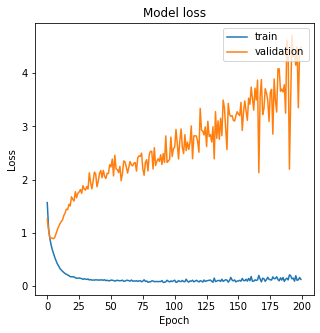

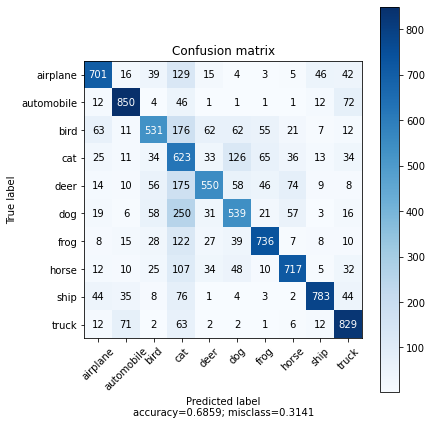

In [8]:
from utils import plot_loss_function
from utils import plot_confusion_matrix
from utils import plot_classification_map

# ---
# obtener etiquetas predichas a partir del modelo, mediante model.predict
Y_pred = model.predict(X_test)

# para que el resultado nos sea más intuitivo transformaremos
# las etiquetas nuevamente a non one-hot-encoding
# utilizando np.argmax
Y_pred = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_test, axis = 1)

# plot gráfico de función de pérdida
plot_loss_function(train_history)

# matriz de confusión
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(Y_true, Y_pred,
                      target_names=class_names, figsize=(6, 6))

## 4.4 Comparación parametros entrenables

Una vez entrenado y evaluado la red, se puede corrobar si los parámetros entrenables del modelo (weights/pesos) realmente fueron modificados. Para lograr esto, se visualizarán estos parámetros para las primeras capas de la red. 



### Antes de entrenar
En la imagen siguiente se puede ver una representación de los parametros que componen una capa tipo Conv2D, las cuales en vez de componerse de nodos se componen de filtros/kernels. En este caso, cada cuadrado de colores de dimensiones 3x3 corresponde a uno de los filtros, los cuales contienen la información de los parámetros entrenables.

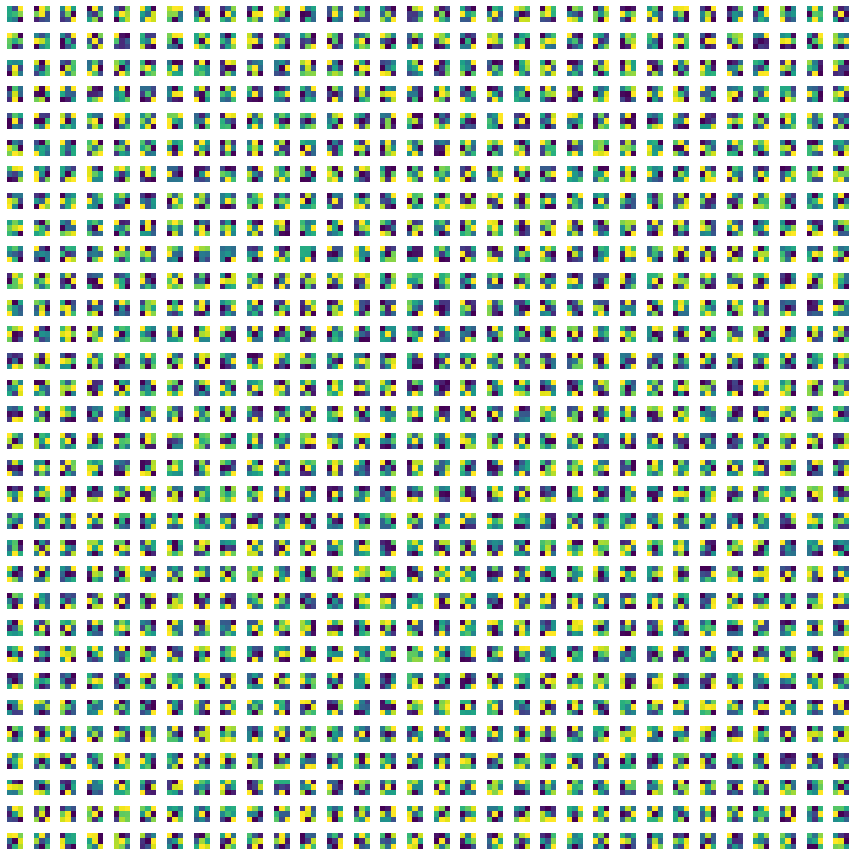

In [73]:
#Visualización parametros antes de entrenar la red
fig,axs = plt.subplots(32,32, figsize = (12,12))
for i in range(32):
  for j in range(32):
    axs[i,j].axis("off")
    axs[i,j].imshow(weights_before_training_2[:,:,i,j])
fig.tight_layout()
plt.show()

### Después de entrenar

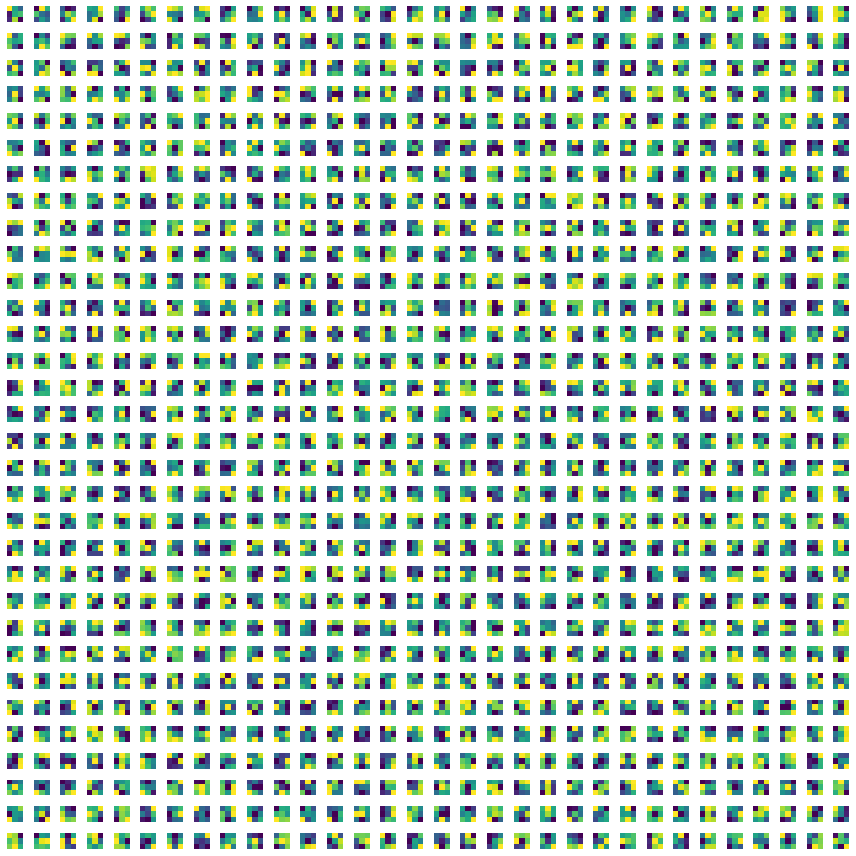

In [75]:
#Visualización parametros después de entrenar la red
fig,axs = plt.subplots(32,32, figsize = (12,12))
for i in range(32):
  for j in range(32):
    axs[i,j].axis("off")
    axs[i,j].imshow(weights_after_training_2[:,:,i,j])
fig.tight_layout()
plt.show()

### Otras capas
Este bloque de codigo permite corroborar si los parametros en cada una de las capas de la red fueron modificados luego de entrenar el modelo. Si entrega "False", entonces los parametros fueron modificados, mientras que si entrega "True", los parametros no cambiaron.

In [76]:
import tensorflow as tf

#Chequea capa a capa si los parámetros fueron modificados
print('Empezar la comparación de pesos entrenables')
for i in range(len(weights_before_training)):
    print(f'Los parámetros de la capa {i + 1} son iguales:', 
      tf.reduce_all(tf.equal(weights_before_training[i], weights_after_training[i])).numpy())
print('Fin de la comparación de pesos entrenables')

Empezar la comparación de pesos entrenables
Los parámetros de la capa 1 son iguales: False
Los parámetros de la capa 2 son iguales: False
Los parámetros de la capa 3 son iguales: False
Los parámetros de la capa 4 son iguales: False
Los parámetros de la capa 5 son iguales: False
Los parámetros de la capa 6 son iguales: False
Los parámetros de la capa 7 son iguales: False
Los parámetros de la capa 8 son iguales: False
Los parámetros de la capa 9 son iguales: False
Los parámetros de la capa 10 son iguales: False
Los parámetros de la capa 11 son iguales: False
Los parámetros de la capa 12 son iguales: False
Los parámetros de la capa 13 son iguales: False
Los parámetros de la capa 14 son iguales: False
Los parámetros de la capa 15 son iguales: False
Los parámetros de la capa 16 son iguales: False
Fin de la comparación de pesos entrenables


## 4.5 Explorando la red

Es posible observar y analizar el comportamiento de nuestra red, observando lo que hace cada una de las capas que configuramos, para ello, debemos generar un modelo nuevo que devuelva como output la evaluación de las capas superiores en vez de el resultado final.

Nos vamos a enfocar en las capas que estudian las imágenes de manera matricial, es decir, las capas bidimensionales:



In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model('model.h5')

layers_outputs = [layer.output for layer in model.layers[:6]]
activation_model = tf.keras.Model(inputs = model.input, outputs = layers_outputs)
activations = activation_model.predict(X_test)

Una vez definido, podemos ver si funciona de manera correcta, mostrando su resumen y asegurandonos de que devuelva la cantidad de capas correctas:

In [ ]:
print("len(activations) = ",len(activations))
activation_model.summary()

Una vez confirmado que la definimos de manera correcta, comenzamos a graficar las capas para poder observar sus parametros y que operacion realiza cada nodo sobre la imagen de entrada:

### CAPA 1

In [ ]:
# Elige una imagen para ver como es interpretada por la red
img = 3000
print("predicción = ", class_names[Y_pred[img]])
print("Clasificacion real = ", class_names[Y_true[img]])

# Seleccionar la capa (indices en python parten del 0)
l = 0

# Mostrar la imagen original
plt.imshow(X_test[img])
plt.title("IMAGEN ORIGINAL")
plt.show()

# Extraer informacion de la capa seleccionada
layer_activation = activations[l][img]

# Graficar informacion almacenada en los nodos de la capa
fig,axs = plt.subplots(4,8, figsize = (15,8))
# fig.suptitle("LAYER "+str(l), fontsize = 15)
for i in range(4):
  for j in range(8):
    axs[i,j].axis("off")
    axs[i,j].imshow(layer_activation[:,:,i*4+j], cmap = "gray")
fig.tight_layout()
plt.show()

### CAPA 2

In [ ]:
l = 1

layer_activation = activations[l][img]

fig,axs = plt.subplots(4,8, figsize = (15,8))
# fig.suptitle("LAYER "+str(l), fontsize = 15)
for i in range(4):
  for j in range(8):
    axs[i,j].axis("off")
    axs[i,j].imshow(layer_activation[:,:,i*4+j], cmap = "gray")
fig.tight_layout()
plt.show()

### CAPA 3

In [ ]:
l = 2

layer_activation = activations[l][img]

print(layer_activation.shape)

fig,axs = plt.subplots(4,8, figsize = (15,8))
# fig.suptitle("LAYER "+str(l), fontsize = 15)
for i in range(4):
  for j in range(8):
    axs[i,j].axis("off")
    axs[i,j].imshow(layer_activation[:,:,i*4+j], cmap = "gray")
fig.tight_layout()
plt.show()

### CAPA 4

In [ ]:
l = 3

layer_activation = activations[l][img]

print(layer_activation.shape)

fig,axs = plt.subplots(6,8, figsize = (15,12))
# fig.suptitle("LAYER "+str(l), fontsize = 15)
for i in range(6):
  for j in range(8):
    axs[i,j].axis("off")
    axs[i,j].imshow(layer_activation[:,:,i*4+j], cmap = "gray")
fig.tight_layout()
plt.show()

### CAPA 5

In [ ]:
l = 4

layer_activation = activations[l][img]

print(layer_activation.shape)

fig,axs = plt.subplots(6,8, figsize = (15,12))
# fig.suptitle("LAYER "+str(l), fontsize = 15)
for i in range(6):
  for j in range(8):
    axs[i,j].axis("off")
    axs[i,j].imshow(layer_activation[:,:,i*4+j], cmap = "gray")
fig.tight_layout()
plt.show()

### CAPA 6

In [ ]:
l = 5

layer_activation = activations[l][img]

print(layer_activation.shape)

fig,axs = plt.subplots(6,8, figsize = (15,12))
# fig.suptitle("LAYER "+str(l), fontsize = 15)
for i in range(6):
  for j in range(8):
    axs[i,j].axis("off")
    axs[i,j].imshow(layer_activation[:,:,i*4+j], cmap = "gray")
fig.tight_layout()
plt.show()

## 4.6 Preguntas
- Modifique la arquitectura de la red hasta mejorarla lo más posible (un _val_acc_ sobre 0.6 o 0.7 es suficiente). Agregue a su reporte un esquema de la arquitectura de su red e incluya los gráficos resultantes. Comente sobre el desempeño en la clasificación. ¿Entre que clases suele confundirse más? ¿Tienen sentido estas confusiones?
- Comente sobre la accion que realiza cada capa y cada nodo de esta sobre la imagen, es posible observar alguna operación vista en visión computacional?
- Compare el efecto de modificar la red sobre las operaciones que realiza cada capa, se observa algun patron? cambia la función de cada capa?
- Ahora, cree otra red que trabaje con los sets (X_dc_train, X_dc_test, Y_dc_train y Y_dc_test) para desarrollar una red que clasifique entre perros y gatos. Trate de mejorarla lo más posible y comente sobre los resultados.
